## Battery Simulation

In [1]:
import os
import pvlib
import pybamm
import urllib.parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

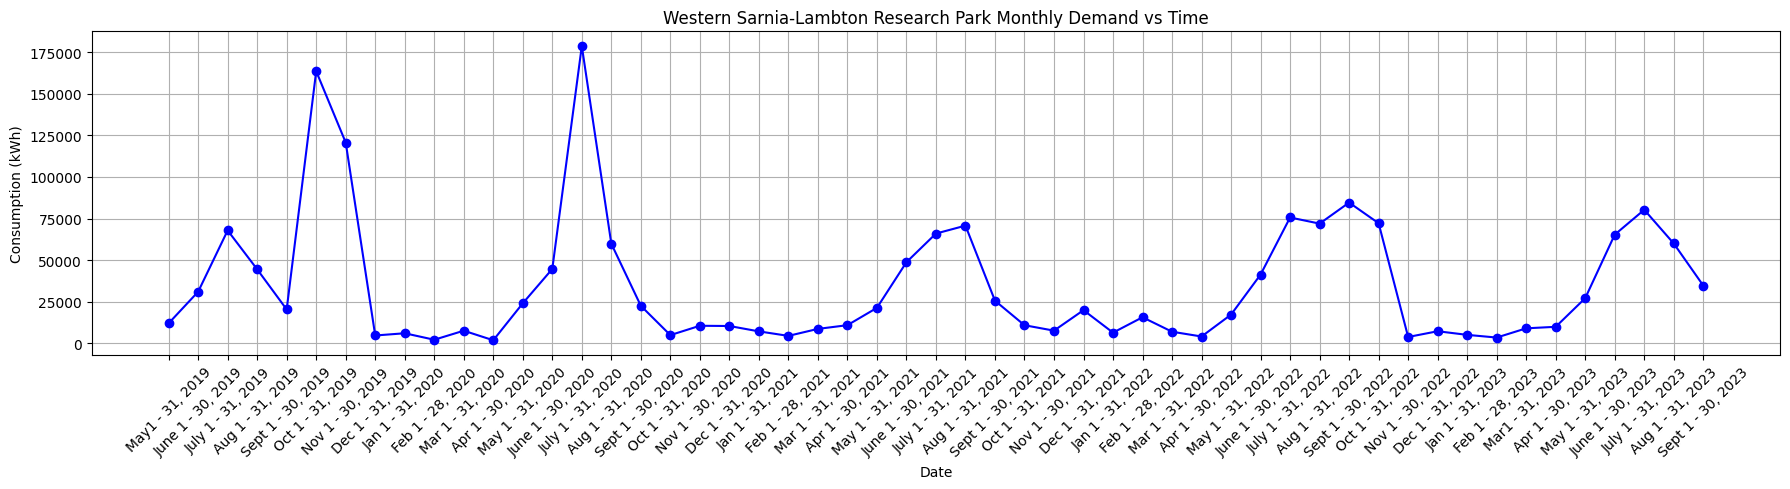

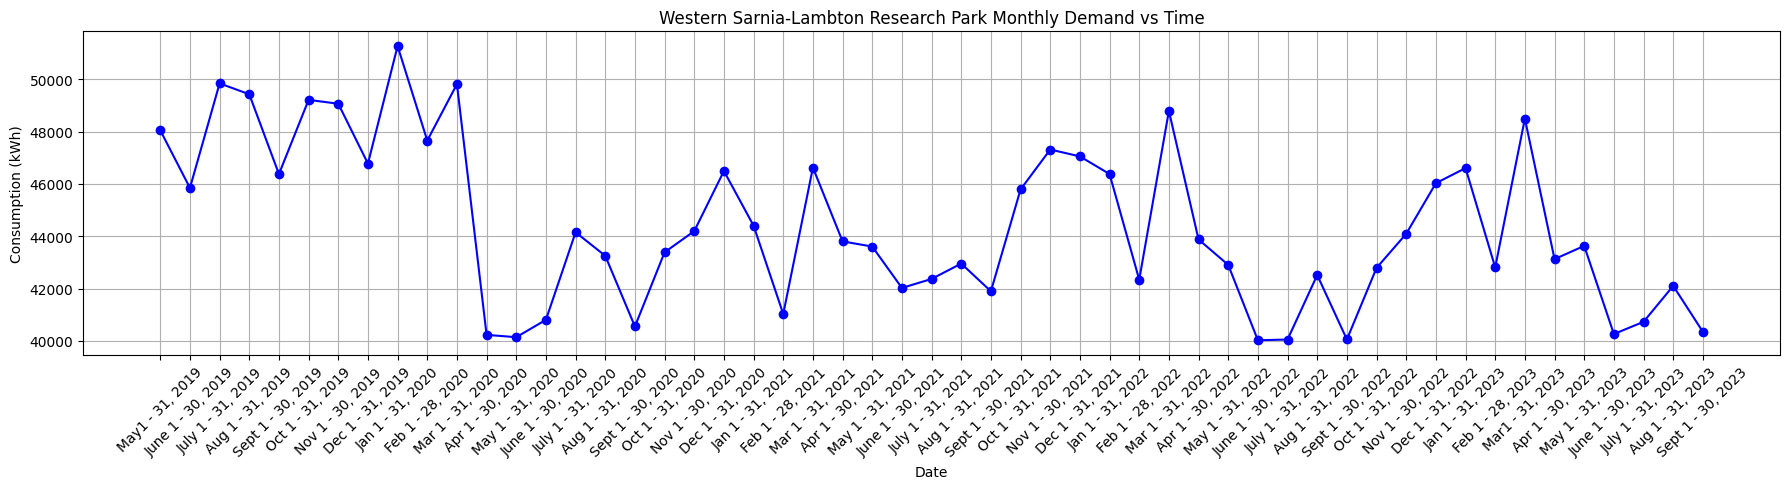

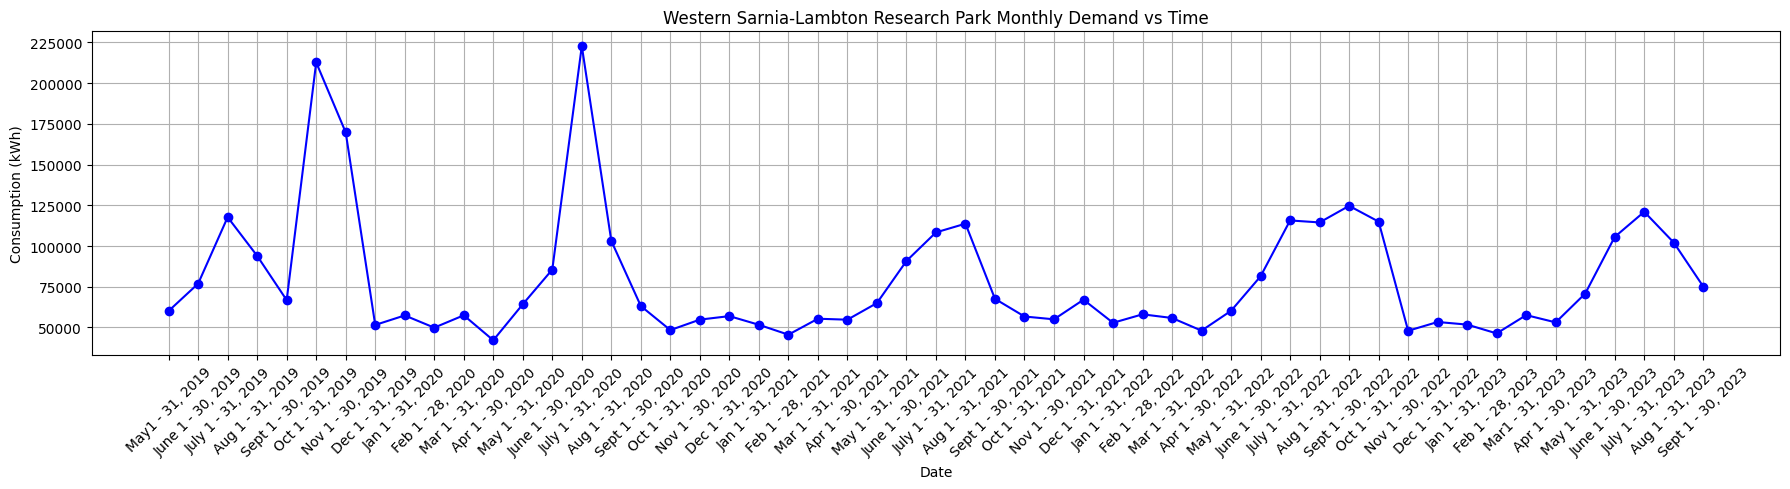

In [2]:
file_path = './data/Research_Park_Electricity_Bills.xlsx'
sheet_name=['Base', '1050', 'Total']
research_park_consumption = pd.read_excel(file_path, sheet_name)

for sheet in sheet_name:
    sheet_df = research_park_consumption[sheet]
    sheet_df.columns = sheet_df.iloc[0]
    sheet_df = sheet_df.drop(0)
    
    # Plot energy consumption vs time
    plt.figure(figsize=(18, 5))
    plt.plot(sheet_df['Date'], sheet_df['Consumption'], marker='o', linestyle='-', color='blue')
    plt.title('Western Sarnia-Lambton Research Park Monthly Demand vs Time')
    plt.xlabel('Date')
    plt.ylabel('Consumption (kWh)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
    plt.show()

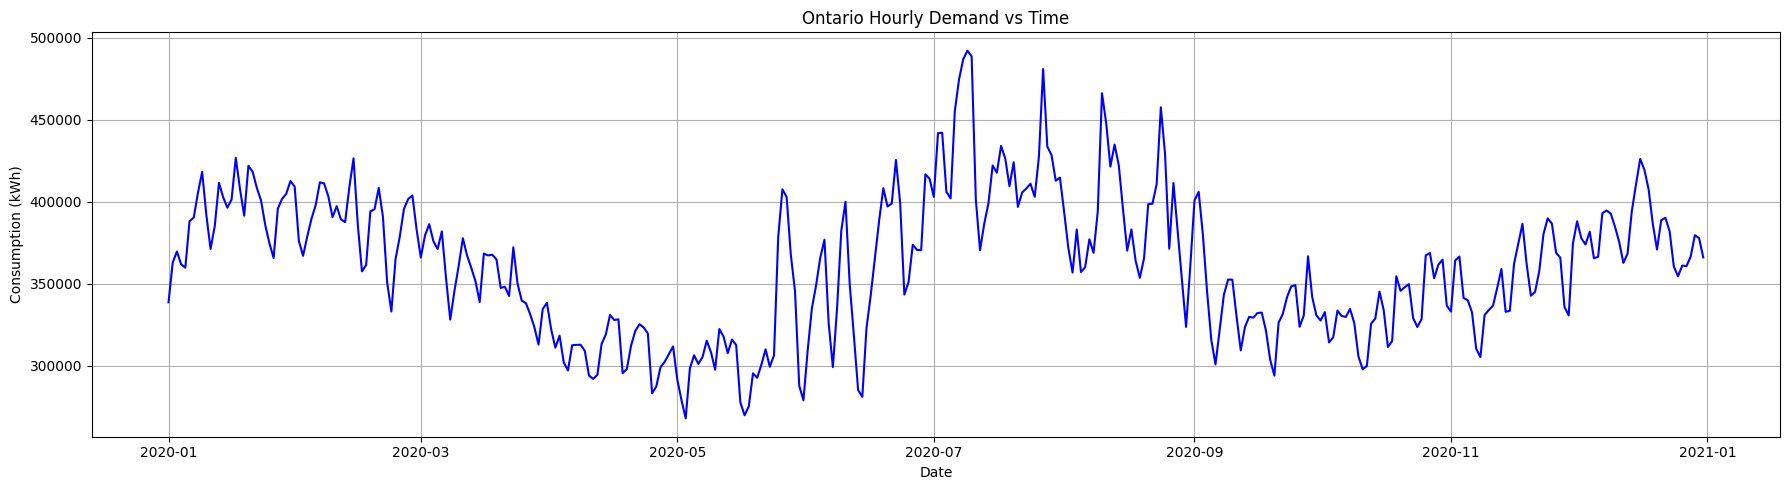

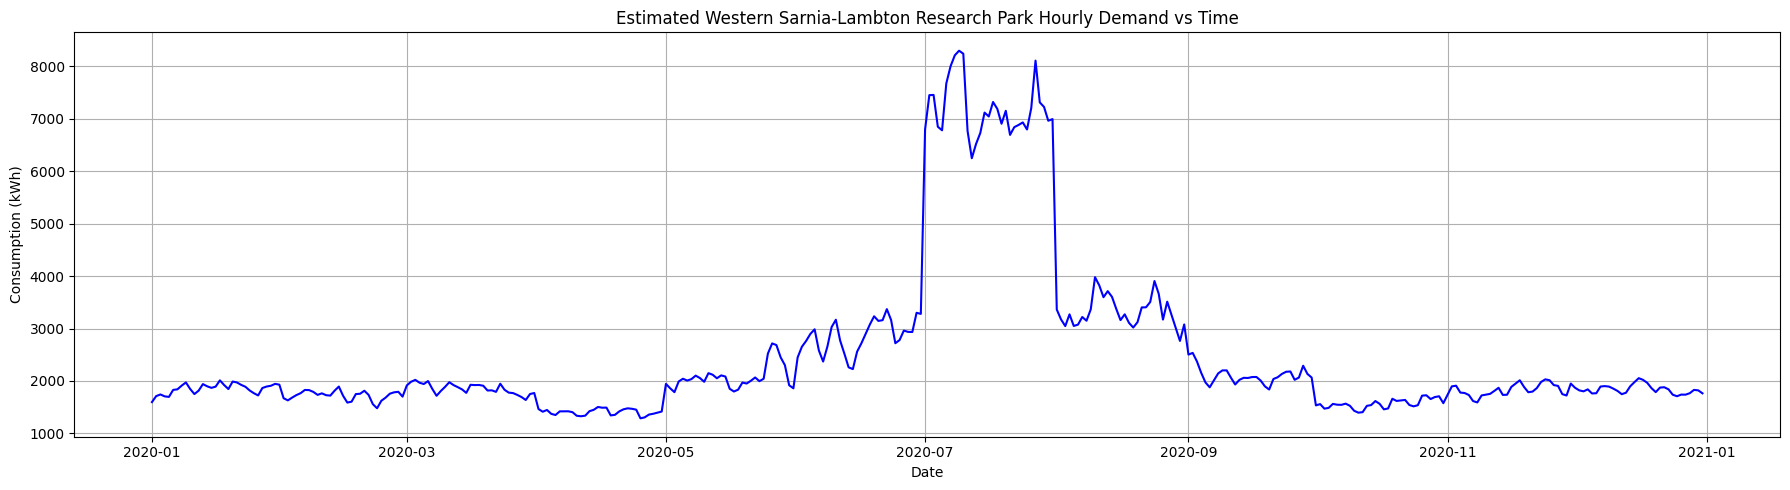

Date
2020-01-01 00:00:00    62.299384
2020-01-01 01:00:00    60.772415
2020-01-01 02:00:00    59.165328
2020-01-01 03:00:00    58.251032
2020-01-01 04:00:00    58.218042
                         ...    
2020-12-31 19:00:00    80.857635
2020-12-31 20:00:00     77.82722
2020-12-31 21:00:00     75.85191
2020-12-31 22:00:00    72.710685
2020-12-31 23:00:00    70.653471
Name: Site Demand, Length: 8784, dtype: object

In [3]:
file_path = './data/PUB_Demand_2020.csv'
df = pd.read_csv(file_path)

df['Hour'] = df['Hour'].astype(int) % 24
df['Hour'] = (pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00') - pd.Timedelta(hours=1)).dt.hour
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00')
df['Month'] = df['Date'].dt.month
df.set_index("Date", inplace=True)

plt.figure(figsize=(18, 5))
plot_data = df['Ontario Demand'].resample('h').mean().resample('d').sum()
plt.plot(plot_data.index, plot_data, linestyle='-', color='blue')
plt.title('Ontario Hourly Demand vs Time')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

monthly_totals = df.groupby('Month')[['Market Demand', 'Ontario Demand']].sum()
monthly_metered = research_park_consumption["Total"].iloc[9:21].copy().reset_index(drop=True)
monthly_metered.index += 1
ratio = monthly_metered['Consumption'] / monthly_totals['Ontario Demand']
df['Site Demand'] = df['Month'].map(ratio) * df['Ontario Demand']
park_con = df['Site Demand']

plt.figure(figsize=(18, 5))
plot_data = df['Site Demand'].resample('h').mean().resample('d').sum()
plt.plot(plot_data.index, plot_data, linestyle='-', color='blue')
plt.title('Estimated Western Sarnia-Lambton Research Park Hourly Demand vs Time')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

park_con

In [4]:
print(park_con.sum()/1000, " MWh")
print(park_con.head(24 * 31).sum()/1000, " MWh")

906.0099999999998  MWh
57.396  MWh


In [5]:
# system parameters
latitude = 42.98
longitude = -82.33

location_id = '4067972'
year = '2020'

weather_data_path = "./data/4067972_2020.csv"

modules_per_string = 6
strings_per_inverter = 1344

cec_module_db = pvlib.pvsystem.retrieve_sam('cecmod')
module_parameters = cec_module_db['First_Solar__Inc__FS_4117_3']
module_parameters['Technology'] = 'CdTe'

temperature_model_parameters = dict(u0=25.0, u1=6.84)
module_unit_mass = 12 / 0.72    # kg/m^2, taken from datasheet values

cec_inverter_db = pvlib.pvsystem.retrieve_sam('cecinverter')
inverter_parameters = cec_inverter_db['TMEIC__PVL_L1833GRM']
losses_parameters = dict(shading=0, availability=0)

pitch = 7                           # meters
gcr = (4 * 0.6 + 3 * 0.01) / pitch  # unitless
max_angle = 60                      # degrees
backtrack = False
axis_azimuth = 180                  # degrees
axis_height = 1.5                   # meters

File exist


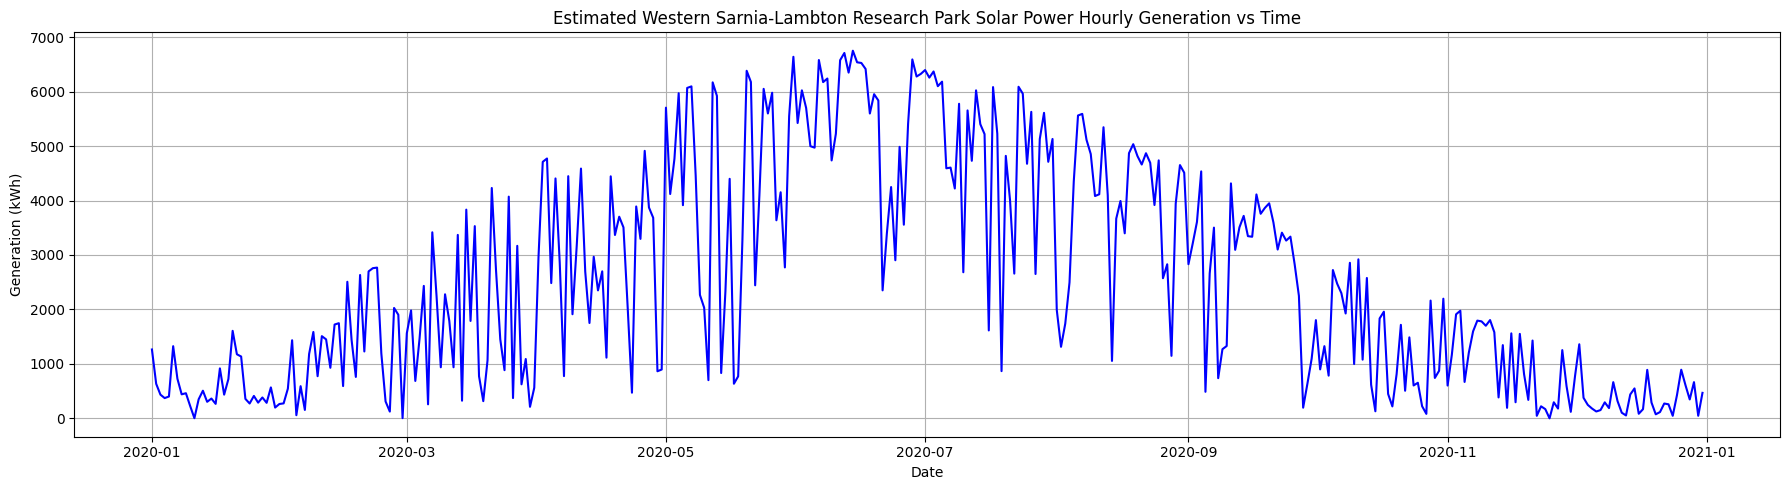

2020-01-01 00:00:00   -0.5499
2020-01-01 01:00:00   -0.5499
2020-01-01 02:00:00   -0.5499
2020-01-01 03:00:00   -0.5499
2020-01-01 04:00:00   -0.5499
                        ...  
2020-12-31 19:00:00   -0.5499
2020-12-31 20:00:00   -0.5499
2020-12-31 21:00:00   -0.5499
2020-12-31 22:00:00   -0.5499
2020-12-31 23:00:00   -0.5499
Freq: h, Length: 8784, dtype: float64

In [6]:
mount = pvlib.pvsystem.SingleAxisTrackerMount(
    gcr=gcr,
    backtrack=backtrack,
    max_angle=max_angle,
    axis_azimuth=axis_azimuth
)
array = pvlib.pvsystem.Array(
    mount=mount,
    module_parameters=module_parameters,
    modules_per_string=modules_per_string,
    temperature_model_parameters=temperature_model_parameters,
    strings=strings_per_inverter
)
system = pvlib.pvsystem.PVSystem(
    array,
    inverter_parameters=inverter_parameters,
    losses_parameters=losses_parameters
)
# get solar position
location = pvlib.location.Location(latitude, longitude)
#
model = pvlib.modelchain.ModelChain(
    system,
    location,
    spectral_model='first_solar',
    aoi_model='physical',
    losses_model='pvwatts'
)
# get weather data
if (os.path.isfile(weather_data_path)):
    print("File exist")
else:
    input_data = {
        'interval': '10',
        'to_utc': 'true',
        'location_ids': location_id,
        'api_key': os.getenv('NSRDB_Api_Key'),
        'email': os.getenv('EMAIL'),
        'names': year,
    }
    url = os.getenv('BASE_URL') + urllib.parse.urlencode(input_data, True)
    data = pd.read_csv(url)
    data.to_csv(weather_data_path, index=False) # save the data into csv file
weather = pd.read_csv(
    weather_data_path, 
    skiprows=[0, 1], 
    usecols=['Year','Month','Day','Hour','Minute','DHI','GHI','DNI','Temperature','Wind Speed','Surface Albedo','Precipitable Water']
)
weather = weather.set_index(pd.to_datetime(weather[['Year', 'Month', 'Day', 'Hour', 'Minute']]))
weather = weather.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

solar_position = location.get_solarposition(weather.index)
tracker_angles = mount.get_orientation(
    solar_position['apparent_zenith'],
    solar_position['azimuth']
)

dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)

averaged_irradiance = pvlib.bifacial.infinite_sheds.get_irradiance_poa(
    tracker_angles['surface_tilt'], tracker_angles['surface_azimuth'],
    solar_position['apparent_zenith'], solar_position['azimuth'],
    gcr, axis_height, pitch,
    weather['GHI'], weather['DHI'], weather['DNI'], weather['Surface Albedo'],
    model='haydavies', dni_extra=dni_extra,
)

cell_temperature_steady_state = pvlib.temperature.faiman(
    poa_global=averaged_irradiance['poa_global'],
    temp_air=weather['Temperature'],
    wind_speed=weather['Wind Speed'],
    **temperature_model_parameters,
)

parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
cell_temperature = pvlib.temperature.sapm_cell(
    averaged_irradiance['poa_global'], 
    weather['Temperature'], 
    weather['Wind Speed'], 
    **parameters
    )

weather_inputs = pd.DataFrame({
    'poa_global': averaged_irradiance['poa_global'],
    'poa_direct': averaged_irradiance['poa_direct'],
    'poa_diffuse': averaged_irradiance['poa_diffuse'],
    'cell_temperature': cell_temperature,
    'precipitable_water': weather['Precipitable Water'],  # for the spectral model
})
model.run_model_from_poa(weather_inputs)

plt.figure(figsize=(18, 5))
# ac = (model.results.ac / 1000).head(1440)
solar_gen = pd.Series((model.results.ac / 1000).resample('h').mean())
ac = solar_gen.resample('d').sum()
plt.plot(ac.index, ac, linestyle='-', color='blue')
plt.title('Estimated Western Sarnia-Lambton Research Park Solar Power Hourly Generation vs Time')
plt.xlabel('Date')
plt.ylabel('Generation (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

solar_gen

                     i_sc  v_oc  i_mp  v_mp  p_mp  i_x  i_xx
2020-01-01 00:00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2020-01-01 00:10:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2020-01-01 00:20:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2020-01-01 00:30:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2020-01-01 00:40:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
...                   ...   ...   ...   ...   ...  ...   ...
2020-12-31 23:10:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2020-12-31 23:20:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2020-12-31 23:30:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2020-12-31 23:40:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2020-12-31 23:50:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0

[52560 rows x 7 columns]
930.8942396392675 MWh
518.2540275567878 MWh


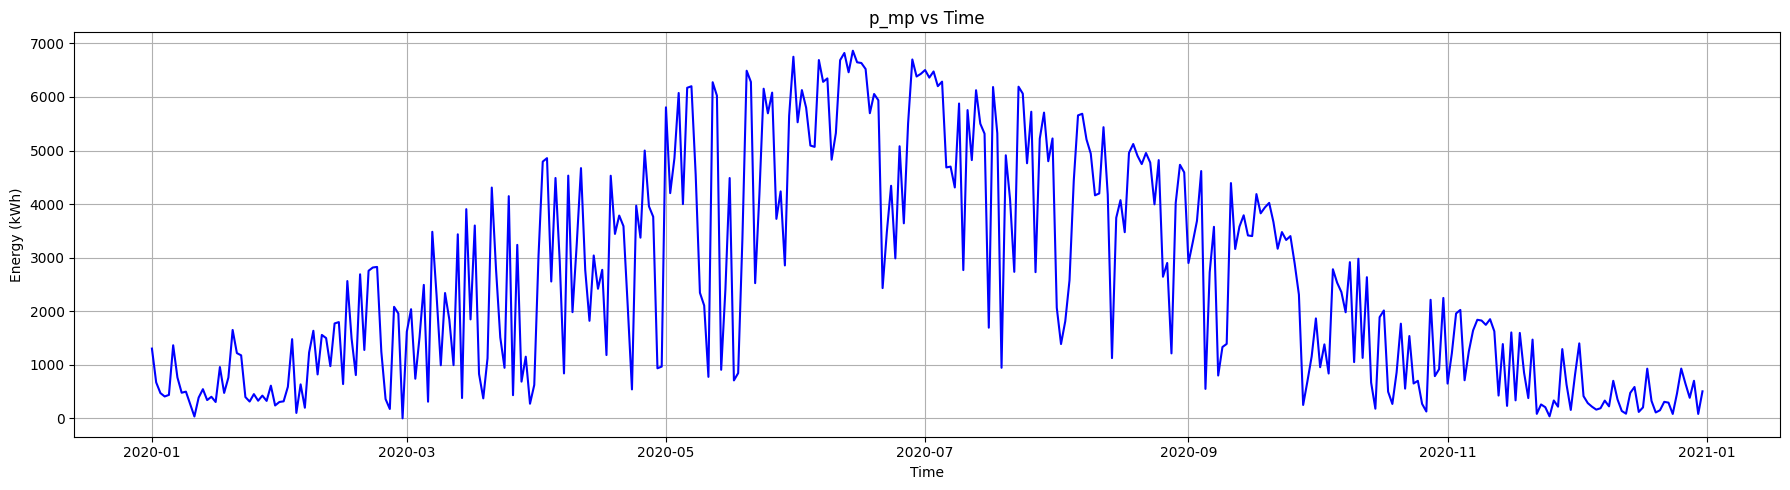

In [7]:
print(model.results.dc)
print(solar_gen.sum()/1000,"MWh")
print(solar_gen.head(6 * 24 * 31).sum()/1000,"MWh")

plt.figure(figsize=(18, 5))
p_mp = (model.results.dc['p_mp'] / 6 / 1000).resample('d').sum()
plt.plot(p_mp.index, p_mp, linestyle='-', color='blue')
plt.title('p_mp vs Time')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

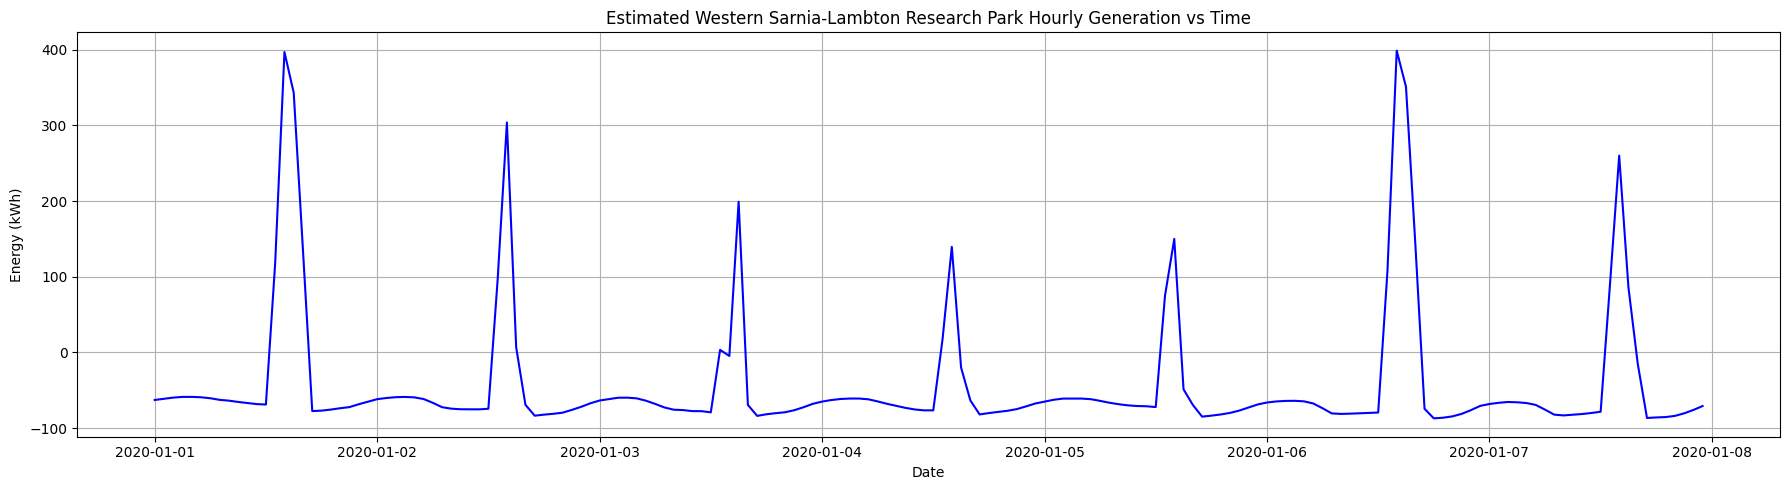

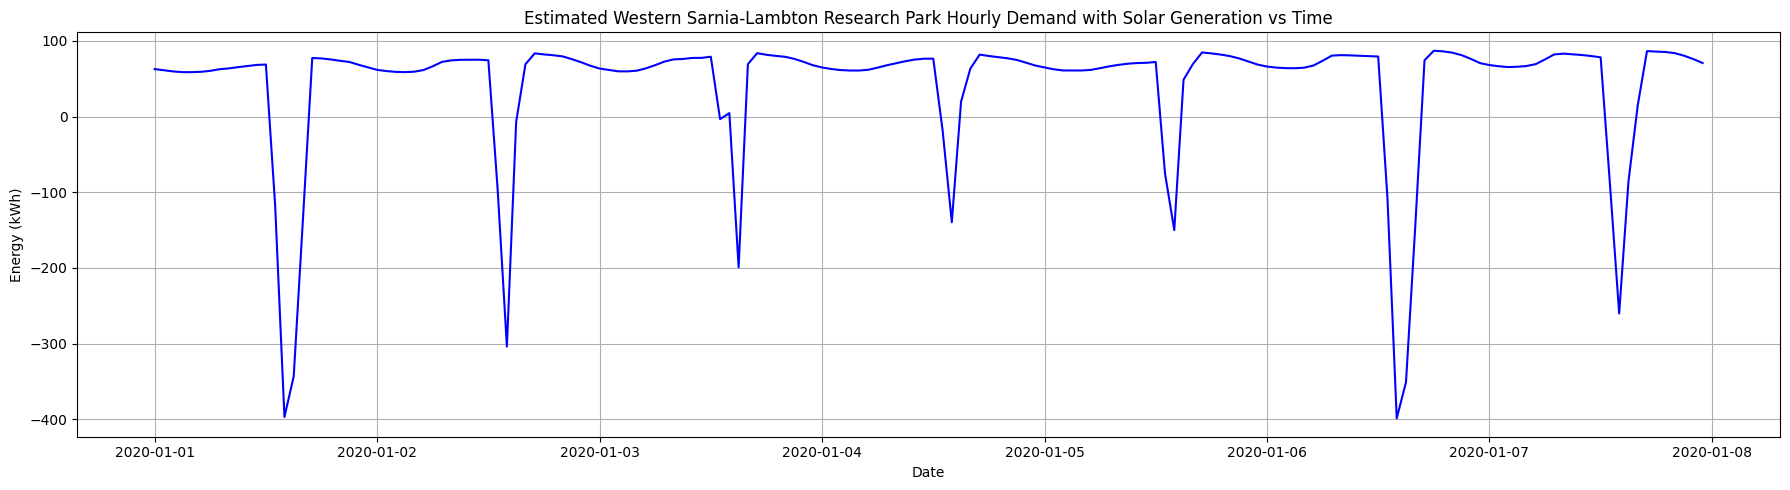

Date
2020-01-01 00:00:00    62.849284
2020-01-01 01:00:00    61.322315
2020-01-01 02:00:00    59.715228
2020-01-01 03:00:00    58.800932
2020-01-01 04:00:00    58.767942
                         ...    
2020-12-31 19:00:00    81.407535
2020-12-31 20:00:00     78.37712
2020-12-31 21:00:00     76.40181
2020-12-31 22:00:00    73.260585
2020-12-31 23:00:00    71.203371
Length: 8784, dtype: object

In [8]:
residual_gen = solar_gen - park_con

rg = residual_gen.head(24 * 7).copy()
plt.figure(figsize=(18, 5))
plt.plot(rg.index, rg, linestyle='-', color='blue')
plt.title('Estimated Western Sarnia-Lambton Research Park Hourly Generation vs Time')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

residual_load = park_con - solar_gen

rl = residual_load.head(24 * 7).copy()
plt.figure(figsize=(18, 5))
plt.plot(rl.index, rl, linestyle='-', color='blue')
plt.title('Estimated Western Sarnia-Lambton Research Park Hourly Demand with Solar Generation vs Time')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

residual_load

### OCV-SOC curve for lithium-ion battery cell

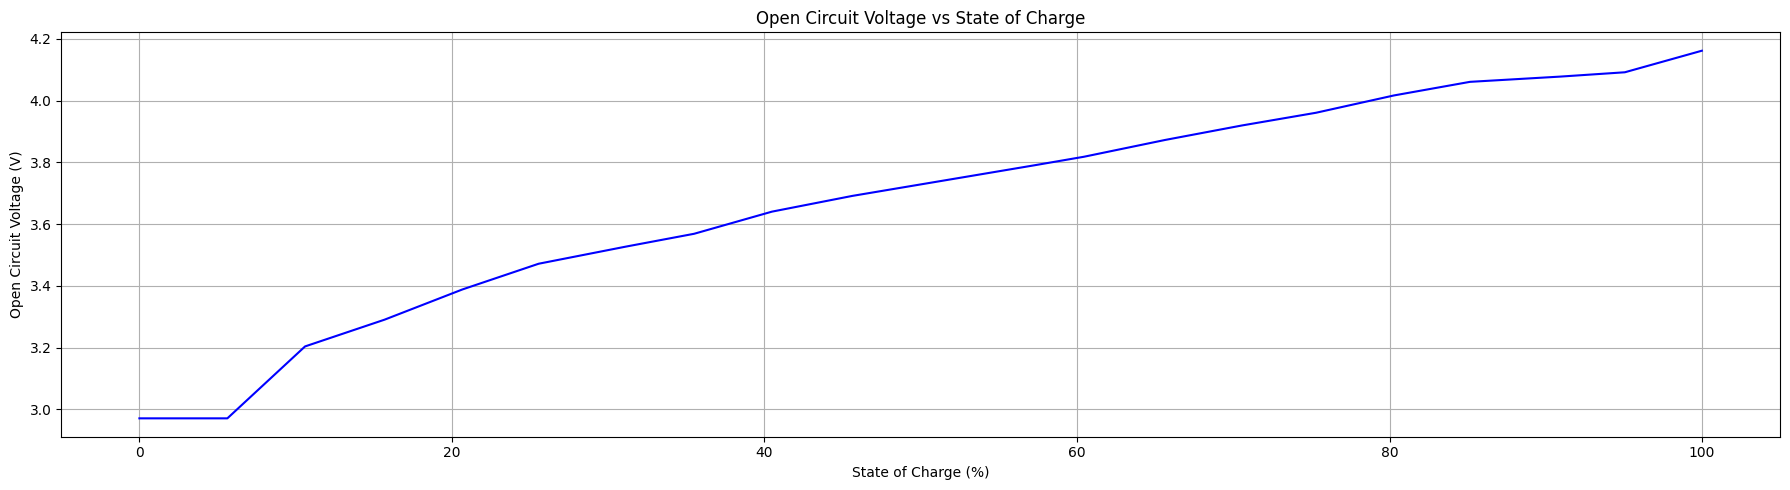

In [9]:

# Reference: https://www.e3s-conferences.org/articles/e3sconf/pdf/2021/10/e3sconf_icies2020_00097.pdf

def voltage_soc_curve(soc):    
    # Open Circuit Voltage (V) points
    ocv_points = np.array([2.971, 3.2037, 3.2880, 3.3860, 3.4712, 3.5208, 3.5677, 3.6396, 3.6892, 3.7317, 3.7735, 3.8163, 3.8687, 3.9164, 3.9592, 4.0153, 4.0606, 4.0749, 4.0913, 4.1617])
    # State of Charge (%) points
    soc_points = np.array([0.0563, 0.1059, 0.1556, 0.2053, 0.2550, 0.3046, 0.3543, 0.4040, 0.4537, 0.5034, 0.5530, 0.6027, 0.6524, 0.7020, 0.7517, 0.8013, 0.8510, 0.9007, 0.9503, 1.0000])
    
    open_circuit_voltage = np.interp(soc, soc_points, ocv_points)
    return open_circuit_voltage

index = range(0,10000,1)
value = []
for soc in index:
    value.append(voltage_soc_curve(soc / 10000))
ocv_soc_curve = pd.Series(value, index = index)
plt.figure(figsize=(18, 5))
plt.plot(ocv_soc_curve.index / 100, ocv_soc_curve, linestyle='-', color='blue')
plt.title('Open Circuit Voltage vs State of Charge')
plt.xlabel('State of Charge (%)')
plt.ylabel('Open Circuit Voltage (V)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Battery Simulation - 0% to 100% SOC TODO: 20% 

In [10]:
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues("Ai2020")

parameter_values["Open-circuit voltage at 0% SOC [V]"] = 2.9
parameter_values["Open-circuit voltage at 100% SOC [V]"] = 4.2

print("Open-circuit voltage at 0% SOC [V]:\t", parameter_values["Open-circuit voltage at 0% SOC [V]"])
print("Open-circuit voltage at 100% SOC [V]:\t", parameter_values["Open-circuit voltage at 100% SOC [V]"])
print("Nominal cell capacity [A.h]:\t\t", parameter_values["Nominal cell capacity [A.h]"])
print("Nominal cell capacity [W.h]:\t\t", parameter_values["Nominal cell capacity [A.h]"] * 3.6)

energy_available_per_megapack_2_hour = 168.6e3 # 2-hour
energy_available_per_megapack_4_hour = 174.4e3 # 4-hour

maximum_soc = 1
minimum_soc = 0

upper_cutoff = voltage_soc_curve(80) # 80% 
lower_cutoff = voltage_soc_curve(10) # 10% 

num_megapack = 1

month = 1

num_cells = int(num_megapack * energy_available_per_megapack_2_hour / ( parameter_values["Nominal cell capacity [A.h]"] * 3.6))

print("Number of battery cells:\t\t", num_cells)

parameter_values

Open-circuit voltage at 0% SOC [V]:	 2.9
Open-circuit voltage at 100% SOC [V]:	 4.2
Nominal cell capacity [A.h]:		 2.28
Nominal cell capacity [W.h]:		 8.208
Number of battery cells:		 20540


{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.38,
 'Cell cooling surface area [m2]': 0.0060484,
 'Cell emissivity': 0.95,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 1.5341e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 2.28,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.051,
 'Electrode width [m]': 0.047,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Ai2020 at 0x7f8d6a9fd870>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Ai2020 at 0x7f8d65945d80>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 

In [11]:
battery_usage = (residual_load[residual_load.index.month.isin([month])] * 1000 / num_cells).copy() # January

experiment = pybamm.Experiment([
    "Discharge at 1C until 3.0 V",
    "Rest for 3 minutes"
    ])
sim_cccv = pybamm.Simulation(model, parameter_values=parameter_values, experiment=experiment)
sol_cccv = sim_cccv.solve()
# sol_cccv.plot()

soc = 0
status = "..."
for (index, power_value) in battery_usage.items():
    v_t = sol_cccv["Voltage [V]"].entries
    res = v_t[len(v_t)-1]

    if power_value < 0 and res < upper_cutoff:
        status = "Charge"
        experiment = pybamm.Experiment([
            "Charge at " + str(int(-power_value)) + "W for 55 minutes or until " + str(voltage_soc_curve(maximum_soc)) + "V",
            "Rest for 5 minutes"
            ])
    elif power_value > 0 and res > lower_cutoff:
        status = "Discharge"
        experiment = pybamm.Experiment([
            "Discharge at " + str(int(power_value)) + "W for 55 minutes or until " + str(voltage_soc_curve(minimum_soc)) + "V",
            "Rest for 5 minutes"
            ])
    else:
        status = "Rest"
        experiment = pybamm.Experiment([("Rest for 1 hour")])
    sim_cccv = pybamm.Simulation(
        model, 
        parameter_values=parameter_values, 
        experiment=experiment, 
        solver=pybamm.CasadiSolver())
    sol_cccv = sim_cccv.solve()
    model = model.set_initial_conditions_from(sol_cccv, inplace=True)
    # sol_cccv.plot(["Voltage [V]","Current [A]"])
    # print(v_t)
    v_t = sol_cccv["Voltage [V]"].entries
    v_0 = v_t[0]
    v_1 = v_t[len(v_t)-1]
    battery_usage[index] = v_1
    print("%s\tResidual_load:%.4f\tVoltage: %.4f -> %.4f\t%s" % (index, power_value, v_0, v_1, status))

2020-07-01 00:00:00	Residual_load:11.7324	Voltage: 4.1841 -> 4.1841	Rest


At t = 137.936 and h = 9.03523e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 137.936 and h = 6.05637e-21, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-01 01:00:00	Residual_load:11.0860	Voltage: 4.0660 -> 2.9710	Discharge
2020-07-01 02:00:00	Residual_load:10.6498	Voltage: 3.2225 -> 3.4779	Rest


At t = 66.7858 and h = 3.59348e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.7857 and h = 4.62434e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.7857 and h = 4.7105e-17, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-01 03:00:00	Residual_load:10.4304	Voltage: 3.2907 -> 2.9710	Discharge
2020-07-01 04:00:00	Residual_load:10.3491	Voltage: 3.2040 -> 3.3887	Rest
2020-07-01 05:00:00	Residual_load:10.4921	Voltage: 3.3887 -> 3.3887	Rest
2020-07-01 06:00:00	Residual_load:11.3152	Voltage: 3.3887 -> 3.3887	Rest
2020-07-01 07:00:00	Residual_load:12.5293	Voltage: 3.3887 -> 3.3887	Rest
2020-07-01 08:00:00	Residual_load:13.3359	Voltage: 3.3887 -> 3.3887	Rest
2020-07-01 09:00:00	Residual_load:14.0588	Voltage: 3.3887 -> 3.3887	Rest
2020-07-01 10:00:00	Residual_load:-0.7154	Voltage: 3.3887 -> 3.3887	Charge
2020-07-01 11:00:00	Residual_load:-18.4144	Voltage: 3.6459 -> 4.1617	Charge
2020-07-01 12:00:00	Residual_load:-25.8635	Voltage: 3.9875 -> 3.8866	Rest


At t = 485.801, , mxstep steps taken before reaching tout.


2020-07-01 13:00:00	Residual_load:-24.8071	Voltage: 4.0788 -> 4.1617	Charge
2020-07-01 14:00:00	Residual_load:-23.0322	Voltage: 3.9704 -> 3.9000	Rest
2020-07-01 15:00:00	Residual_load:-20.4312	Voltage: 3.9000 -> 3.8996	Rest
2020-07-01 16:00:00	Residual_load:-17.4924	Voltage: 4.0478 -> 4.1617	Charge
2020-07-01 17:00:00	Residual_load:-14.2131	Voltage: 4.0139 -> 3.9360	Rest
2020-07-01 18:00:00	Residual_load:-9.2929	Voltage: 3.9360 -> 3.9359	Rest
2020-07-01 19:00:00	Residual_load:0.9580	Voltage: 3.9359 -> 3.9359	Discharge


At t = 360.041 and h = 2.69831e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 120.04 and h = 6.72512e-20, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-01 20:00:00	Residual_load:15.0635	Voltage: 3.7937 -> 2.9710	Discharge
2020-07-01 21:00:00	Residual_load:15.0051	Voltage: 3.2766 -> 3.5786	Rest


At t = 82.5228 and h = 7.89704e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.5228 and h = 8.78339e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.5228 and h = 5.24222e-19, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-01 22:00:00	Residual_load:13.8953	Voltage: 3.3768 -> 2.9710	Discharge
2020-07-01 23:00:00	Residual_load:12.7757	Voltage: 3.2353 -> 3.4631	Rest


At t = 52.2942 and h = 3.14216e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 52.2942 and h = 3.14242e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 52.2942 and h = 3.14359e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 52.2942 and h = 3.14276e-16, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-02 00:00:00	Residual_load:11.8762	Voltage: 3.2623 -> 2.9710	Discharge
2020-07-02 01:00:00	Residual_load:11.2470	Voltage: 3.2149 -> 3.3921	Rest
2020-07-02 02:00:00	Residual_load:10.9225	Voltage: 3.3921 -> 3.3921	Rest
2020-07-02 03:00:00	Residual_load:10.8026	Voltage: 3.3921 -> 3.3921	Rest
2020-07-02 04:00:00	Residual_load:10.9003	Voltage: 3.3921 -> 3.3921	Rest
2020-07-02 05:00:00	Residual_load:11.3620	Voltage: 3.3921 -> 3.3921	Rest
2020-07-02 06:00:00	Residual_load:12.4512	Voltage: 3.3921 -> 3.3921	Rest
2020-07-02 07:00:00	Residual_load:13.8953	Voltage: 3.3921 -> 3.3921	Rest
2020-07-02 08:00:00	Residual_load:15.0232	Voltage: 3.3921 -> 3.3921	Rest
2020-07-02 09:00:00	Residual_load:15.8405	Voltage: 3.3921 -> 3.3921	Rest
2020-07-02 10:00:00	Residual_load:2.1836	Voltage: 3.3921 -> 3.3921	Rest
2020-07-02 11:00:00	Residual_load:-15.4689	Voltage: 3.6263 -> 4.1617	Charge
2020-07-02 12:00:00	Residual_load:-22.8742	Voltage: 4.0102 -> 3.9260	Rest
2020-07-02 13:00:00	Residual_load:-21.9737	

At t = 359.006 and h = 2.3671e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.006 and h = 8.22796e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.006 and h = 3.68357e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.0058 and h = 7.04182e-18, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-02 20:00:00	Residual_load:16.4613	Voltage: 3.6310 -> 2.9710	Discharge
2020-07-02 21:00:00	Residual_load:16.1379	Voltage: 3.2881 -> 3.5962	Rest


At t = 83.7586 and h = 8.20295e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 83.7586 and h = 2.13436e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 83.7586 and h = 1.28722e-19, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-02 22:00:00	Residual_load:14.6174	Voltage: 3.3886 -> 2.9710	Discharge
2020-07-02 23:00:00	Residual_load:13.3515	Voltage: 3.2449 -> 3.4821	Rest


At t = 51.1345 and h = 2.02636e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.1345 and h = 2.50759e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.1345 and h = 6.1113e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.1345 and h = 2.01854e-17, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-03 00:00:00	Residual_load:12.5030	Voltage: 3.2737 -> 2.9710	Discharge
2020-07-03 01:00:00	Residual_load:11.8606	Voltage: 3.2251 -> 3.4101	Rest


At t = 37.0729 and h = 1.61423e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 37.0728 and h = 2.07436e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 37.0729 and h = 1.06999e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 37.0729 and h = 7.7839e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 37.0729 and h = 6.00998e-18, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-03 02:00:00	Residual_load:11.3792	Voltage: 3.2005 -> 2.9710	Discharge
2020-07-03 03:00:00	Residual_load:11.2437	Voltage: 3.2151 -> 3.3634	Rest
2020-07-03 04:00:00	Residual_load:11.3250	Voltage: 3.3634 -> 3.3634	Rest
2020-07-03 05:00:00	Residual_load:11.7341	Voltage: 3.3634 -> 3.3634	Rest
2020-07-03 06:00:00	Residual_load:12.7929	Voltage: 3.3634 -> 3.3634	Rest
2020-07-03 07:00:00	Residual_load:13.9052	Voltage: 3.3634 -> 3.3634	Rest
2020-07-03 08:00:00	Residual_load:14.8351	Voltage: 3.3634 -> 3.3634	Rest
2020-07-03 09:00:00	Residual_load:15.7181	Voltage: 3.3634 -> 3.3634	Rest
2020-07-03 10:00:00	Residual_load:1.4545	Voltage: 3.3634 -> 3.3634	Rest
2020-07-03 11:00:00	Residual_load:-16.2637	Voltage: 3.6099 -> 4.1617	Charge
2020-07-03 12:00:00	Residual_load:-24.0901	Voltage: 4.0024 -> 3.9119	Rest
2020-07-03 13:00:00	Residual_load:-22.7656	Voltage: 3.9119 -> 3.9140	Rest
2020-07-03 14:00:00	Residual_load:-20.8681	Voltage: 3.9140 -> 3.9137	Rest
2020-07-03 15:00:00	Residual_load:-18.381

At t = 536.48 and h = 1.50471e-19, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-03 20:00:00	Residual_load:16.0923	Voltage: 3.6792 -> 2.9710	Discharge
2020-07-03 21:00:00	Residual_load:15.7206	Voltage: 3.2886 -> 3.5992	Rest


At t = 85.849 and h = 6.98514e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 85.8491 and h = 2.24903e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 85.8491 and h = 2.25422e-17, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-03 22:00:00	Residual_load:14.5484	Voltage: 3.3923 -> 2.9710	Discharge
2020-07-03 23:00:00	Residual_load:13.4657	Voltage: 3.2450 -> 3.4837	Rest


At t = 51.6433 and h = 4.42509e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.6433 and h = 3.53891e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.6434 and h = 2.55209e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.6434 and h = 3.03805e-16, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-04 00:00:00	Residual_load:12.6500	Voltage: 3.2755 -> 2.9710	Discharge
2020-07-04 01:00:00	Residual_load:11.9238	Voltage: 3.2251 -> 3.4109	Rest


At t = 37.267 and h = 7.60832e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 37.267 and h = 7.61282e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 37.267 and h = 7.58382e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 37.267 and h = 9.88245e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 37.267 and h = 7.61286e-18, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-04 02:00:00	Residual_load:11.4055	Voltage: 3.2014 -> 2.9710	Discharge
2020-07-04 03:00:00	Residual_load:10.9512	Voltage: 3.2151 -> 3.3638	Rest
2020-07-04 04:00:00	Residual_load:10.6925	Voltage: 3.3638 -> 3.3638	Rest
2020-07-04 05:00:00	Residual_load:10.7204	Voltage: 3.3638 -> 3.3638	Rest
2020-07-04 06:00:00	Residual_load:11.4556	Voltage: 3.3638 -> 3.3638	Rest
2020-07-04 07:00:00	Residual_load:12.4225	Voltage: 3.3638 -> 3.3638	Rest
2020-07-04 08:00:00	Residual_load:13.2776	Voltage: 3.3638 -> 3.3638	Rest
2020-07-04 09:00:00	Residual_load:14.1040	Voltage: 3.3638 -> 3.3638	Rest
2020-07-04 10:00:00	Residual_load:-1.1858	Voltage: 3.3970 -> 3.6777	Charge
2020-07-04 11:00:00	Residual_load:-12.8180	Voltage: 3.8130 -> 4.1617	Charge
2020-07-04 12:00:00	Residual_load:-20.8868	Voltage: 4.0362 -> 3.9689	Rest
2020-07-04 13:00:00	Residual_load:-17.0021	Voltage: 3.9689 -> 3.9705	Rest
2020-07-04 14:00:00	Residual_load:-21.8947	Voltage: 3.9705 -> 3.9709	Rest
2020-07-04 15:00:00	Residual_load:-20.

At t = 69.9054 and h = 1.14418e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 69.9054 and h = 1.12493e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 69.9054 and h = 2.2807e-19, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-04 22:00:00	Residual_load:13.3384	Voltage: 3.3469 -> 2.9710	Discharge
2020-07-04 23:00:00	Residual_load:12.2984	Voltage: 3.2350 -> 3.4521	Rest


At t = 48.748 and h = 1.11324e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 48.748 and h = 1.1103e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 48.748 and h = 1.11352e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 48.748 and h = 1.11131e-16, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-05 00:00:00	Residual_load:11.6174	Voltage: 3.2494 -> 2.9710	Discharge
2020-07-05 01:00:00	Residual_load:11.0490	Voltage: 3.2149 -> 3.3865	Rest
2020-07-05 02:00:00	Residual_load:10.4740	Voltage: 3.3865 -> 3.3865	Rest
2020-07-05 03:00:00	Residual_load:10.2284	Voltage: 3.3865 -> 3.3865	Rest
2020-07-05 04:00:00	Residual_load:10.0772	Voltage: 3.3865 -> 3.3865	Rest
2020-07-05 05:00:00	Residual_load:10.0107	Voltage: 3.3865 -> 3.3865	Rest
2020-07-05 06:00:00	Residual_load:10.5512	Voltage: 3.3865 -> 3.3865	Rest
2020-07-05 07:00:00	Residual_load:11.3891	Voltage: 3.3865 -> 3.3865	Rest
2020-07-05 08:00:00	Residual_load:12.2639	Voltage: 3.3865 -> 3.3865	Rest
2020-07-05 09:00:00	Residual_load:13.2653	Voltage: 3.3865 -> 3.3865	Rest
2020-07-05 10:00:00	Residual_load:-1.5838	Voltage: 3.4185 -> 3.6790	Charge
2020-07-05 11:00:00	Residual_load:-17.8208	Voltage: 3.8524 -> 4.1617	Charge
2020-07-05 12:00:00	Residual_load:-25.4828	Voltage: 3.9967 -> 3.9017	Rest
2020-07-05 13:00:00	Residual_load:-24.03

At t = 136.188 and h = 5.972e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 136.188 and h = 5.97151e-20, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-05 20:00:00	Residual_load:15.6233	Voltage: 3.5782 -> 2.9710	Discharge
2020-07-05 21:00:00	Residual_load:15.4323	Voltage: 3.2732 -> 3.5685	Rest


At t = 68.5799 and h = 4.84289e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 68.5799 and h = 2.2544e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 68.5799 and h = 4.89039e-20, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-05 22:00:00	Residual_load:14.2847	Voltage: 3.3555 -> 2.9710	Discharge
2020-07-05 23:00:00	Residual_load:13.1018	Voltage: 3.2444 -> 3.4685	Rest


At t = 46.9013 and h = 4.6561e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 46.9012 and h = 7.60346e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 46.9013 and h = 1.18255e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 46.9013 and h = 6.1033e-18, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-06 00:00:00	Residual_load:12.4989	Voltage: 3.2578 -> 2.9710	Discharge
2020-07-06 01:00:00	Residual_load:11.9353	Voltage: 3.2251 -> 3.4031	Rest


At t = 35.3838 and h = 2.92978e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.3838 and h = 5.85945e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.3838 and h = 6.29287e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.3838 and h = 1.88256e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.3838 and h = 5.8596e-19, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-06 02:00:00	Residual_load:11.5230	Voltage: 3.1924 -> 2.9710	Discharge
2020-07-06 03:00:00	Residual_load:11.3431	Voltage: 3.2151 -> 3.3592	Rest
2020-07-06 04:00:00	Residual_load:11.3784	Voltage: 3.3592 -> 3.3592	Rest
2020-07-06 05:00:00	Residual_load:11.9994	Voltage: 3.3592 -> 3.3592	Rest
2020-07-06 06:00:00	Residual_load:13.2677	Voltage: 3.3592 -> 3.3592	Rest
2020-07-06 07:00:00	Residual_load:14.3882	Voltage: 3.3592 -> 3.3592	Rest
2020-07-06 08:00:00	Residual_load:15.3592	Voltage: 3.3592 -> 3.3592	Rest
2020-07-06 09:00:00	Residual_load:16.1683	Voltage: 3.3592 -> 3.3592	Rest
2020-07-06 10:00:00	Residual_load:2.8370	Voltage: 3.3592 -> 3.3592	Rest
2020-07-06 11:00:00	Residual_load:-14.9716	Voltage: 3.5902 -> 4.1617	Charge
2020-07-06 12:00:00	Residual_load:-22.3739	Voltage: 4.0183 -> 3.9402	Rest
2020-07-06 13:00:00	Residual_load:-16.5255	Voltage: 3.9402 -> 3.9428	Rest
2020-07-06 14:00:00	Residual_load:-3.6543	Voltage: 3.9428 -> 3.9431	Rest
2020-07-06 15:00:00	Residual_load:6.9394	V

At t = 263.053 and h = 4.10328e-19, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-06 16:00:00	Residual_load:7.1270	Voltage: 3.4121 -> 2.9710	Discharge
2020-07-06 17:00:00	Residual_load:-8.0275	Voltage: 3.3598 -> 4.1617	Charge
2020-07-06 18:00:00	Residual_load:-1.8570	Voltage: 4.0729 -> 4.0243	Rest


At t = 58.1976 and h = 3.25933e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.1976 and h = 3.50566e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.1976 and h = 3.50502e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.1978 and h = 1.25188e-17, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-06 19:00:00	Residual_load:8.6828	Voltage: 3.9371 -> 2.9710	Discharge
2020-07-06 20:00:00	Residual_load:17.2206	Voltage: 3.1817 -> 3.3938	Rest
2020-07-06 21:00:00	Residual_load:16.2833	Voltage: 3.3938 -> 3.3938	Rest
2020-07-06 22:00:00	Residual_load:14.9008	Voltage: 3.3938 -> 3.3938	Rest
2020-07-06 23:00:00	Residual_load:13.7286	Voltage: 3.3938 -> 3.3938	Rest
2020-07-07 00:00:00	Residual_load:12.9153	Voltage: 3.3938 -> 3.3938	Rest
2020-07-07 01:00:00	Residual_load:12.2697	Voltage: 3.3938 -> 3.3938	Rest
2020-07-07 02:00:00	Residual_load:11.8064	Voltage: 3.3938 -> 3.3938	Rest
2020-07-07 03:00:00	Residual_load:11.6355	Voltage: 3.3938 -> 3.3938	Rest
2020-07-07 04:00:00	Residual_load:11.6355	Voltage: 3.3938 -> 3.3938	Rest
2020-07-07 05:00:00	Residual_load:12.2097	Voltage: 3.3938 -> 3.3938	Rest
2020-07-07 06:00:00	Residual_load:13.4107	Voltage: 3.3938 -> 3.3938	Rest
2020-07-07 07:00:00	Residual_load:14.8975	Voltage: 3.3938 -> 3.3938	Rest
2020-07-07 08:00:00	Residual_load:15.8512	Volta

At t = 436.691 and h = 5.06353e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 196.691 and h = 9.07666e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 76.6904 and h = 5.50914e-18, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-07 17:00:00	Residual_load:11.4400	Voltage: 3.8317 -> 2.9710	Discharge
2020-07-07 18:00:00	Residual_load:18.3908	Voltage: 3.2222 -> 3.4767	Rest


At t = 49.423 and h = 3.02945e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 49.423 and h = 2.32485e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 49.423 and h = 2.58274e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 49.423 and h = 2.5828e-19, the corrector convergence failed repeatedly or with |h| = hmin.


2020-07-07 19:00:00	Residual_load:12.5542	Voltage: 3.2675 -> 2.9710	Discharge
2020-07-07 20:00:00	Residual_load:18.3624	Voltage: 3.2251 -> 3.4073	Rest


At t = 17.088 and h = 1.24095e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 17.088 and h = 1.28312e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 17.088 and h = 1.24291e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 17.088 and h = 1.34596e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 17.088 and h = 2.74332e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 17.088 and h = 1.34108e-17, the corrector convergence failed repeatedly or with |h| = hmin.
2024-04-20 23:28:51.894 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Maximum number of decreased steps occurred at t=0.0 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "

SolverError: Maximum number of decreased steps occurred at t=0.0 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=600) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_failed_early=True` to return the solution object up to the point where failure occured.

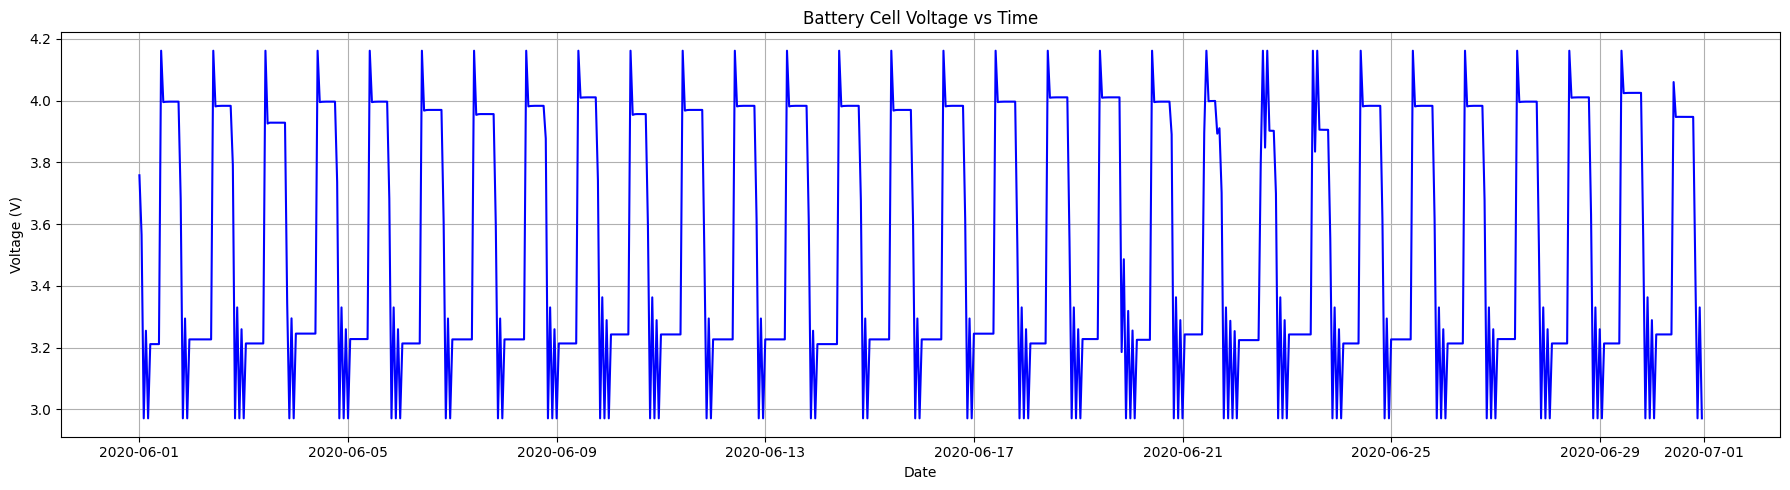

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(battery_usage.index, battery_usage, linestyle='-', color='blue')
plt.title('Battery Cell Voltage vs Time')
plt.xlabel('Date')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.tight_layout()
plt.show()

# battery_usage_list

Date
2020-06-01 00:00:00     86.500435
2020-06-01 01:00:00      84.12405
2020-06-01 02:00:00     83.514111
2020-06-01 03:00:00     84.021073
2020-06-01 04:00:00     87.348013
                          ...    
2020-06-30 19:00:00    153.657092
2020-06-30 20:00:00    148.999376
2020-06-30 21:00:00    140.935508
2020-06-30 22:00:00    129.631834
2020-06-30 23:00:00    120.387694
Name: Site Demand, Length: 720, dtype: object


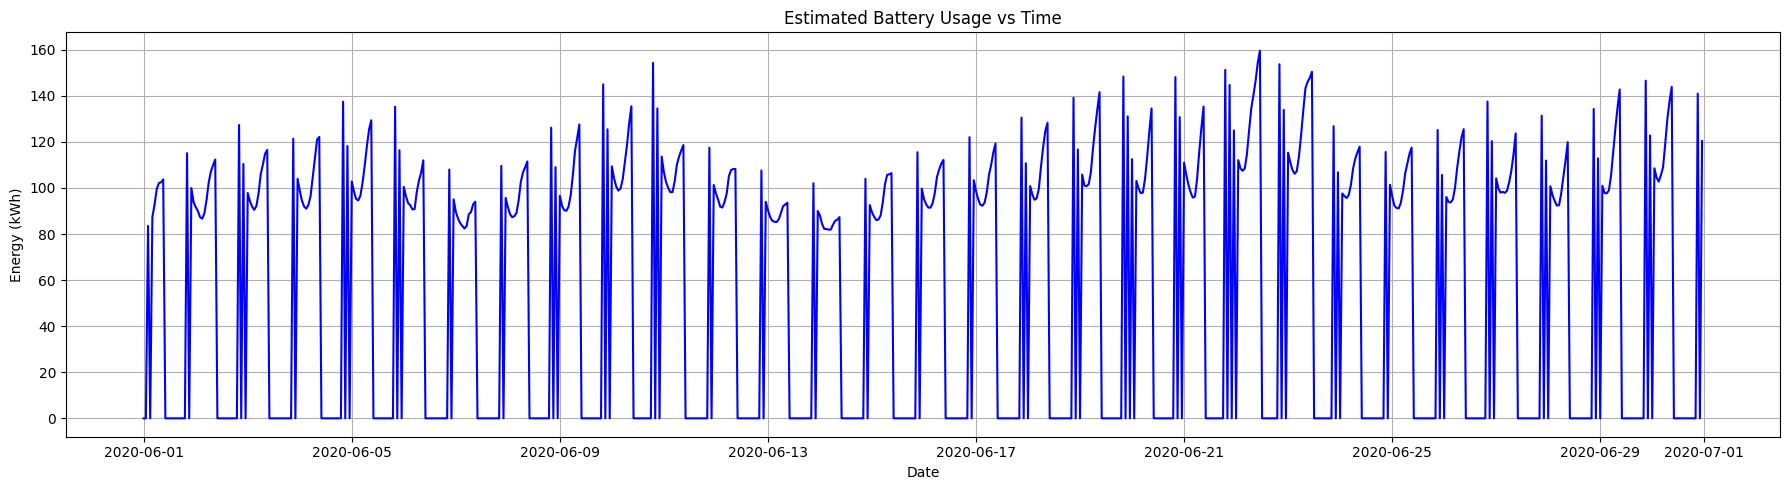

In [ ]:
park_con = park_con[park_con.index.month.isin([month])].copy()
park_con_tmp = park_con[park_con.index.month.isin([month])].copy()
print(park_con)
for (index, value) in battery_usage.items():
    if value > lower_cutoff:
        park_con_tmp[index] = 0
    else:
        park_con_tmp[index] = park_con[index]
        
plt.figure(figsize=(18, 5))
plt.plot(park_con_tmp.index, park_con_tmp, linestyle='-', color='blue')
plt.title('Estimated Battery Usage vs Time')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("Energy consumption without battery:\t", park_con.sum()/1000, "MWh")
print("Energy consumption with battery:\t", park_con_tmp.sum()/1000, "MWh")

print(100 - (park_con_tmp.sum()/1000) * 100 / (park_con.sum()/1000), "%")

Energy consumption without battery:	 85.54999999999998 MWh
Energy consumption with battery:	 37.998872913602426 MWh
55.58284872752492 %


## Electricity Pricing Methods

### Time-of-Use rates

In [ ]:
# Reference: https://www.oeb.ca/consumer-information-and-protection/electricity-rates/historical-electricity-rates

def TOU_electricity_cost(hour, weekday, monthNum):

    on_peak_rate = 0.182    # $0.182 per kWh during peak hours
    mid_peak_rate = 0.122   # $0.122 per kWh during mid-peak hours
    off_peak_rate = 0.087   # $0.087 per kWh during off-peak hours

    on_peak_start = 11      # 11:00 AM
    on_peak_end = 17        #  5:00 PM
    
    mid_peak_start = 7      #  7:00 AM
    mid_peak_end = 19       #  7:00 PM

    if hour >= on_peak_start and hour < on_peak_end and weekday < 5:
        if monthNum >= 5 and monthNum <= 10:
            return on_peak_rate
        else:
            return mid_peak_rate
    elif hour >= mid_peak_start and hour < mid_peak_end and weekday < 5:
        if monthNum >= 5 and monthNum <= 10:
            return mid_peak_rate
        else:
            return on_peak_rate
    else:
        return off_peak_rate

### Ultra-Low Overnight rates

In [ ]:
# Reference: https://www.oeb.ca/consumer-information-and-protection/electricity-rates/historical-electricity-rates

def ULO_electricity_cost(hour, weekday):
    on_peak_rate = 0.286    # $0.286 per kWh during peak hours
    mid_peak_rate = 0.122   # $0.122 per kWh during mid-peak hours
    off_peak_rate = 0.087   # $0.087 per kWh during off-peak hours
    ulo_rate = 0.028        # $0.028 per kWh during ULO hours

    on_peak_start = 16      #  4:00 PM
    on_peak_end = 21        #  9:00 PM
    
    mid_peak_start = 7      #  7:00 AM
    mid_peak_end = 23       # 11:00 PM

    ulo_start = 23          # 11:00 PM
    ulo_end = 7             #  7:00 AM
    
    if ulo_start <= hour < ulo_end:
        return ulo_rate
    elif hour >= on_peak_start and hour < on_peak_end and weekday < 5:
        return on_peak_rate
    elif hour >= mid_peak_start and hour < mid_peak_end and weekday < 5:
        return mid_peak_rate
    else:
        return off_peak_rate

### Tiered rates

In [ ]:
# Reference: https://www.oeb.ca/consumer-information-and-protection/electricity-rates/historical-electricity-rates

def electricity_cost(usage, monthNum, residential):
    tier1_rate = 0.103      # $0.103 per kWh for the first tier
    tier2_rate = 0.125      # $0.125 per kWh for the second tier

    if residential:
        if monthNum >= 5 and monthNum <= 10:
            tier1_threshold = 600   # kWh
        else:
            tier1_threshold = 1000  # kWh
    else:
        tier1_threshold = 750       # kWh
    
    if usage <= tier1_threshold:
        cost = usage * tier1_rate
    else:
        tier1_cost = tier1_threshold * tier1_rate
        tier2_cost = (usage - tier1_threshold) * tier2_rate
        cost = tier1_cost + tier2_cost
    return cost